In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [110]:
# load data

data_day_n1 = pd.read_csv('data/prices_round_2_day_-1.csv', delimiter=';')

data_day_0 = pd.read_csv('data/prices_round_2_day_0.csv', delimiter=';')

data_day_1 = pd.read_csv('data/prices_round_2_day_1.csv', delimiter=';')



day_n1 = pd.read_csv('data/prices_round_2_day_-1.csv', delimiter=';')
day_0 = pd.read_csv('data/prices_round_2_day_0.csv', delimiter=';')
# add the timestamp of the last row of day n1 to day 0 
day_0['timestamp'] = day_0['timestamp'] + day_n1.iloc[-1]['timestamp']
day_1 = pd.read_csv('data/prices_round_2_day_1.csv', delimiter=';')
# add the timestamp of the last row of day 0 to day 1
day_1['timestamp'] = day_1['timestamp'] + day_0.iloc[-1]['timestamp']

data = pd.concat([day_n1, day_0, day_1])

In [111]:
# Calculate relative production of orchids

# If the sunlight exposure is less than 7 hours per day, the production drops 4% every 10 minutes
# Humidity also plays a part: if the humidity is higher than 80% or lower than 60%, production will fall 2% for every 5% change in humidity

# If humidity > 80% then humidity_effect = ((humidity - 80)/5)
# If humidity < 60% then humidity_effect = ((60 - humidity)/5)
data_day_n1['humidity_effect_on_production'] = np.where(data_day_n1['HUMIDITY'] > 80, round((data_day_n1['HUMIDITY'] - 80)/5), np.where(data_day_n1['HUMIDITY'] < 60, round((data_day_n1['HUMIDITY'] - 60)/5), 0))
data_day_0['humidity_effect_on_production'] = np.where(data_day_0['HUMIDITY'] > 80, round((data_day_0['HUMIDITY'] - 80)/5), np.where(data_day_0['HUMIDITY'] < 60, round((data_day_0['HUMIDITY'] - 60)/5), 0))
data_day_1['humidity_effect_on_production'] = np.where(data_day_1['HUMIDITY'] > 80, round((data_day_1['HUMIDITY'] - 80)/5), np.where(data_day_1['HUMIDITY'] < 60, round((data_day_1['HUMIDITY'] - 60)/5), 0))

Text(0, 0.5, 'ORCHIDS')

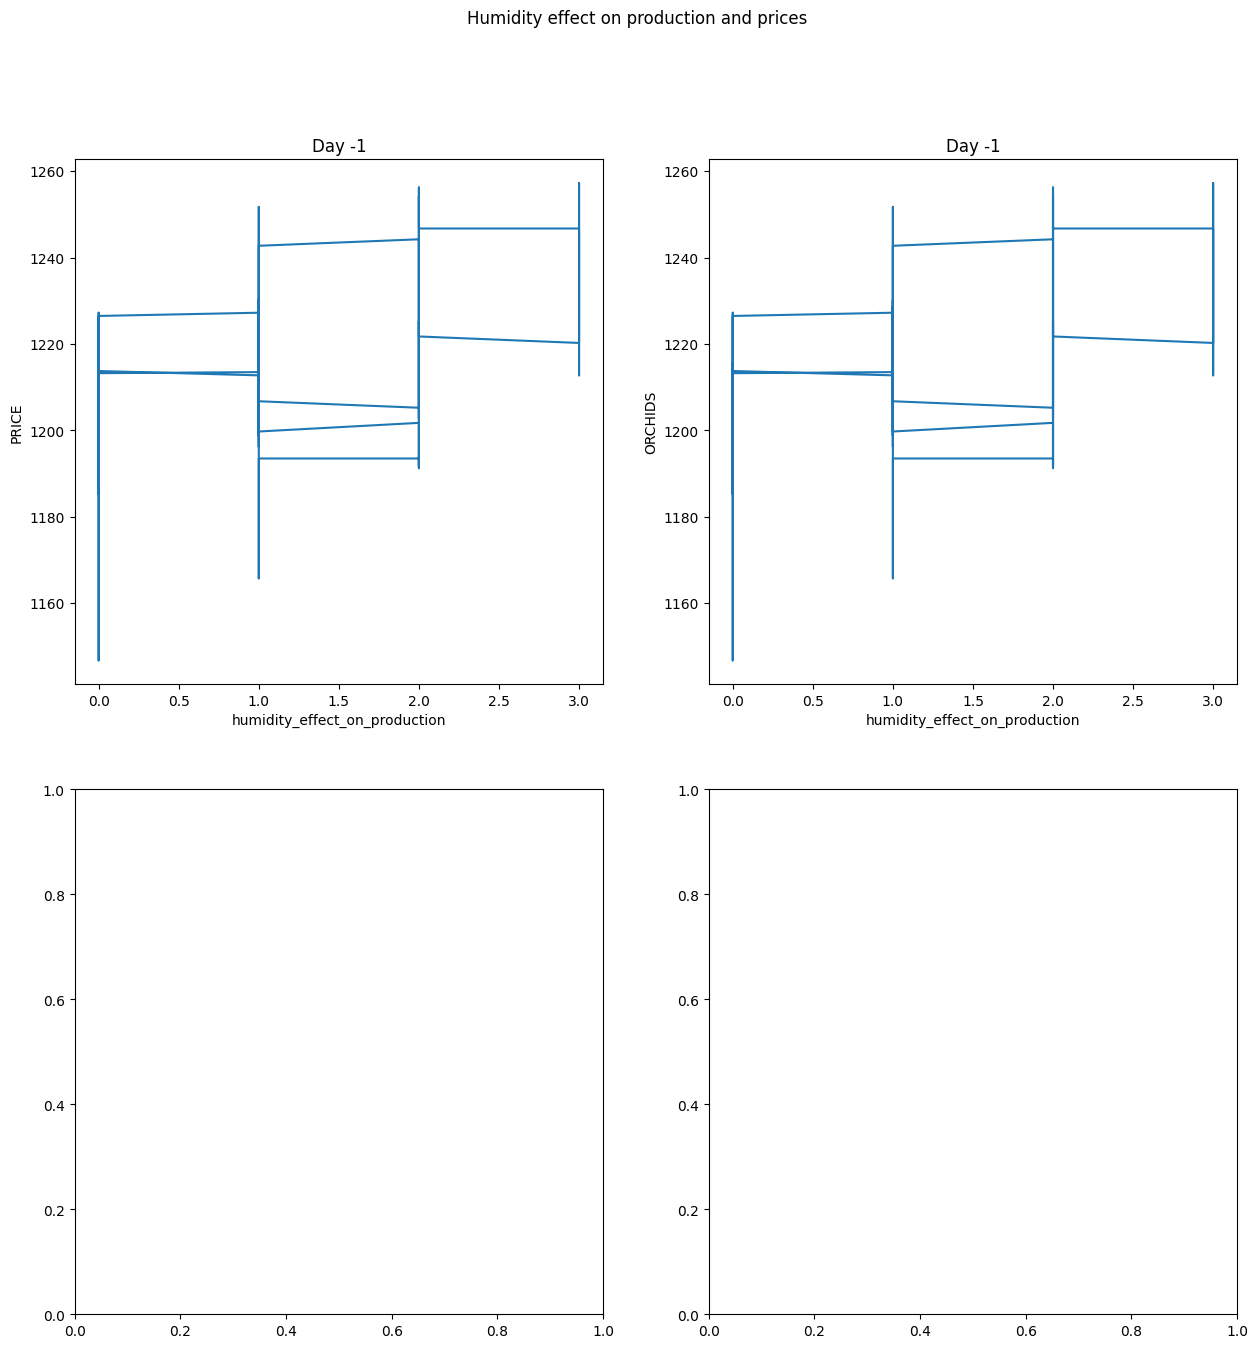

In [112]:
# subplot humidity_effect_on_production and prices 

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Humidity effect on production and prices')

axs[0, 0].plot(data_day_n1['humidity_effect_on_production'], data_day_n1['ORCHIDS'])
axs[0, 0].set_title('Day -1')
axs[0, 0].set_xlabel('humidity_effect_on_production')
axs[0, 0].set_ylabel('PRICE')

axs[0, 1].plot(data_day_n1['humidity_effect_on_production'], data_day_n1['ORCHIDS'])
axs[0, 1].set_title('Day -1')
axs[0, 1].set_xlabel('humidity_effect_on_production')
axs[0, 1].set_ylabel('ORCHIDS')


In [113]:
# since the sunlight column shows the instantaneous sunlight, we need to calculate the total sunlight exposure per day
# threshold for "enough" sunlight is 2500
# assuming the day is 12 hours long, the total sunlight exposure is 2500 * 12 = 30000
# if the sunlight exposure is less than 7 hours per day, the production drops 4% every 10 minutes of not enough sunlight
# There are 10000 tics in 12 hours, so 10 minutes is (10000) / (12 * 6) = 139


# average exposure per day is 2500 
# Each tic is 12*60*60 / 10000 = 4.32 seconds

# That means that if we need 7 hours of sunlight, we need 7 * 60 * 60 / 4.32 = 5833 tics with sunlight exposure over 2500
data_day_n1['enough_sunlight'] = np.where(data_day_n1['SUNLIGHT'] >= 2500, 1, 0)
data_day_0['enough_sunlight'] = np.where(data_day_0['SUNLIGHT'] >= 2500, 1, 0)
data_day_1['enough_sunlight'] = np.where(data_day_1['SUNLIGHT'] >= 2500, 1, 0)


# count the number of tics with enough sunlight
data_day_n1['enough_sunlight_count'] = data_day_n1['enough_sunlight'].sum()
data_day_0['enough_sunlight_count'] = data_day_0['enough_sunlight'].sum()
data_day_1['enough_sunlight_count'] = data_day_1['enough_sunlight'].sum()


In [114]:
# Calculate relative production of orchids based on sunlight exposure

# for every 10 minutes of sunlight exposure less than 7 hours, production drops 4%
# data_day_n1["sunlight_effect_on_production"] = np.where(data_day_n1['SUNLIGHT'] < 7, -0.04, 0)

In [115]:
# Now we want to calculate the probability that the amount of sunlight received in a day is enough to not affect production 
# if the sunlight exposure is above 2500 for 5833, then the production is not affected and the probability that the production will go down is 0%

# if the sunlight exposure is above 2500 for only 5833/2 ticks, then the chances that the production is affected is only 50%

# from here, we want to use the sigmoid function to calculate the probability that the production will be affected


data_day_n1['cumulative_ticks_with_enough_sunlight'] = data_day_n1['enough_sunlight'].cumsum()
data_day_0['cumulative_ticks_with_enough_sunlight'] = data_day_0['enough_sunlight'].cumsum()
data_day_1['cumulative_ticks_with_enough_sunlight'] = data_day_1['enough_sunlight'].cumsum()


# calculate the number of ticks left until the production will not be affected
data_day_n1["ticks_till_production_not_affected"] = np.where(data_day_n1['cumulative_ticks_with_enough_sunlight'] < 5833, (5833 - data_day_n1['cumulative_ticks_with_enough_sunlight']), 0)
data_day_0["ticks_till_production_not_affected"] = np.where(data_day_0['cumulative_ticks_with_enough_sunlight'] < 5833, (5833 - data_day_0['cumulative_ticks_with_enough_sunlight']), 0)
data_day_1["ticks_till_production_not_affected"] = np.where(data_day_1['cumulative_ticks_with_enough_sunlight'] < 5833, (5833 - data_day_1['cumulative_ticks_with_enough_sunlight']), 0)

# calculate the remaning ticks in the day
data_day_n1["remaining_ticks"] = 10000 - data_day_n1.index
data_day_0["remaining_ticks"] = 10000 - data_day_0.index
data_day_1["remaining_ticks"] = 10000 - data_day_1.index


# calculate the probability that the production will be affected
data_day_n1['probability_of_production_drop'] = np.where(data_day_n1["ticks_till_production_not_affected"] > data_day_n1["remaining_ticks"], 1, np.where(data_day_n1['cumulative_ticks_with_enough_sunlight'] < 5833, np.where(data_day_n1['cumulative_ticks_with_enough_sunlight'] <= 5833, 1-data_day_n1['cumulative_ticks_with_enough_sunlight'] / 5833, 0 ), 0))
data_day_0['probability_of_production_drop'] = np.where(data_day_0["ticks_till_production_not_affected"] > data_day_0["remaining_ticks"], 1, np.where(data_day_0['cumulative_ticks_with_enough_sunlight'] < 5833, np.where(data_day_0['cumulative_ticks_with_enough_sunlight'] <= 5833, 1-data_day_0['cumulative_ticks_with_enough_sunlight'] / 5833, 0 ), 0))
data_day_1['probability_of_production_drop'] = np.where(data_day_1["ticks_till_production_not_affected"] > data_day_1["remaining_ticks"], 1, np.where(data_day_1['cumulative_ticks_with_enough_sunlight'] < 5833, np.where(data_day_1['cumulative_ticks_with_enough_sunlight'] <= 5833, 1-data_day_1['cumulative_ticks_with_enough_sunlight'] / 5833, 0 ), 0))



In [116]:
# calculate the effect of sunlight on production




In [117]:
# Add the last timestamp to of day n1 to day 0 
data_day_0['timestamp'] = data_day_0['timestamp'] +data_day_n1['timestamp'].iloc[-1]
data_day_1['timestamp'] = data_day_1['timestamp'] + data_day_0['timestamp'].iloc[-1]

data = pd.concat([data_day_n1, data_day_0, data_day_1])

data

,timestamp,ORCHIDS,TRANSPORT_FEES,EXPORT_TARIFF,IMPORT_TARIFF,SUNLIGHT,HUMIDITY,DAY,humidity_effect_on_production,enough_sunlight,enough_sunlight_count,cumulative_ticks_with_enough_sunlight,ticks_till_production_not_affected,remaining_ticks,probability_of_production_drop
0,0,1200.00,1.5,10.5,-2.0,2500.0000,79.00000,-1,0.0,1,9795,1,5832,10000,0.999829
1,100,1201.75,1.5,9.5,-2.0,2499.4197,79.00410,-1,0.0,0,9795,1,5832,9999,0.999829
2,200,1201.75,1.5,9.5,-2.0,2498.8457,79.00821,-1,0.0,0,9795,1,5832,9998,0.999829
3,300,1201.75,1.5,9.5,-2.0,2498.2780,79.01234,-1,0.0,0,9795,1,5832,9997,0.999829
4,400,1201.75,1.5,9.5,-2.0,2497.7166,79.01649,-1,0.0,0,9795,1,5832,9996,0.999829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2999600,1036.25,0.9,9.5,-5.0,2299.9436,69.93549,1,0.0,0,2775,2775,3058,4,1.000000
9997,2999700,1036.25,0.9,9.5,-5.0,2299.9556,69.95153,1,0.0,0,2775,2775,3058,3,1.000000
9998,2999800,1036.25,0.9,9.5,-5.0,2299.9690,69.96762,1,0.0,0,2775,2775,3058,2,1.000000
9999,2999900,1034.25,0.9,9.5,-5.0,2299.9840,69.98378,1,0.0,0,2775,2775,3058,1,1.000000


In [118]:

# calculate the true cost of an orchid: ask price + import tariff + transport cost 

data_day_n1["true_price"] = data_day_n1["ORCHIDS"] + data_day_n1["IMPORT_TARIFF"] + data_day_n1["TRANSPORT_FEES"]
data_day_0["true_price"] = data_day_0["ORCHIDS"] + data_day_0["IMPORT_TARIFF"] + data_day_0["TRANSPORT_FEES"]
data_day_1["true_price"] = data_day_1["ORCHIDS"] + data_day_1["IMPORT_TARIFF"] + data_day_1["TRANSPORT_FEES"]

data_day_n1["price_difference"] = data_day_n1["true_price"] - data_day_n1["ORCHIDS"]

# potential profit is true price - export tariff - transport fees
data_day_n1["potential_profit"] = data_day_n1["true_price"] - (data_day_n1["ORCHIDS"] - - data_day_n1["EXPORT_TARIFF"] - data_day_n1["TRANSPORT_FEES"])



In [119]:
# adjust the probability of the production drop based on how long along the day is. 

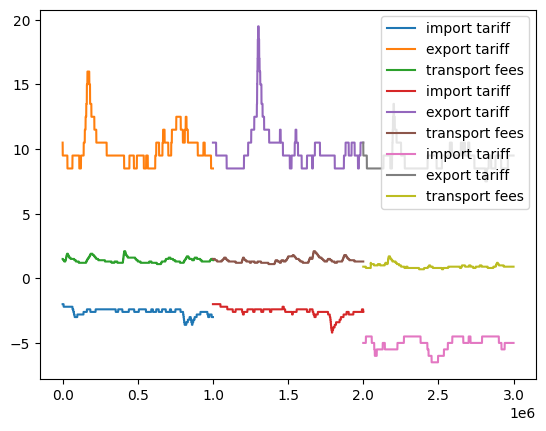

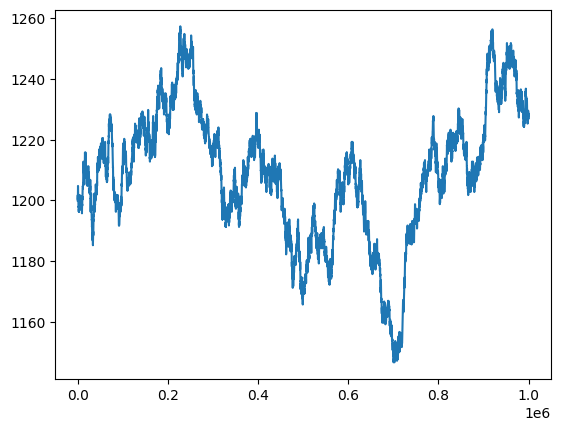

In [120]:
# plot import and export tariffs

plt.plot(data_day_n1['timestamp'], data_day_n1['IMPORT_TARIFF'], label='import tariff')
plt.plot(data_day_n1['timestamp'], data_day_n1['EXPORT_TARIFF'], label='export tariff')
plt.plot(data_day_n1['timestamp'], data_day_n1['TRANSPORT_FEES'], label='transport fees')

plt.plot(data_day_0['timestamp'], data_day_0['IMPORT_TARIFF'], label='import tariff')
plt.plot(data_day_0['timestamp'], data_day_0['EXPORT_TARIFF'], label='export tariff')
plt.plot(data_day_0['timestamp'], data_day_0['TRANSPORT_FEES'], label='transport fees')

plt.plot(data_day_1['timestamp'], data_day_1['IMPORT_TARIFF'], label='import tariff')
plt.plot(data_day_1['timestamp'], data_day_1['EXPORT_TARIFF'], label='export tariff')
plt.plot(data_day_1['timestamp'], data_day_1['TRANSPORT_FEES'], label='transport fees')

plt.legend()
plt.show()

# plot the price of the orchids against the timestamp
plt.plot(data_day_n1['timestamp'], data_day_n1['ORCHIDS'])
plt.show()

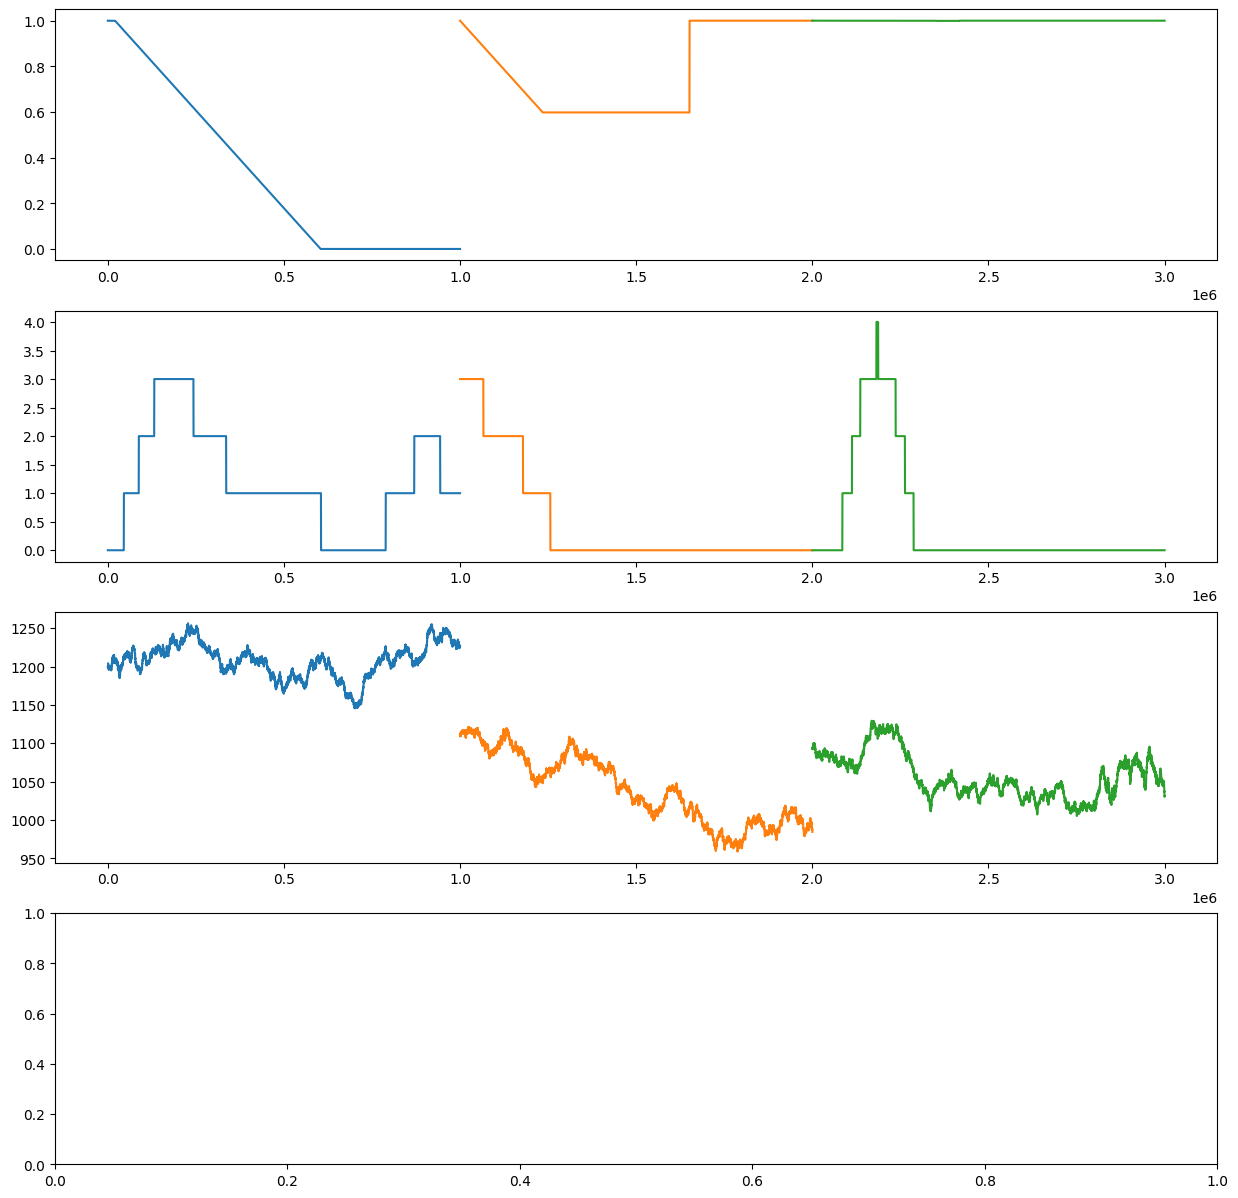

In [121]:
# create a subplot with 4 tables 
fig, axs = plt.subplots(4,1, figsize=(15, 15))

# plot the probability of production drop against the timestamp for the three days
axs[0].plot(data_day_n1['timestamp'], data_day_n1['probability_of_production_drop'], label='day -1')
axs[0].plot(data_day_0['timestamp'], data_day_0['probability_of_production_drop'], label='day 0')
axs[0].plot(data_day_1['timestamp'], data_day_1['probability_of_production_drop'], label='day 1')

# also plot the humidity effect on production
axs[1].plot(data_day_n1['timestamp'], data_day_n1['humidity_effect_on_production'], label='day -1')
axs[1].plot(data_day_0['timestamp'], data_day_0['humidity_effect_on_production'], label='day 0')
axs[1].plot(data_day_1['timestamp'], data_day_1['humidity_effect_on_production'], label='day 1')

# now plot the true price of the orchids
axs[2].plot(data_day_n1['timestamp'], data_day_n1['true_price'], label='day -1')
axs[2].plot(data_day_0['timestamp'], data_day_0['true_price'], label='day 0')
axs[2].plot(data_day_1['timestamp'], data_day_1['true_price'], label='day 1')


45400

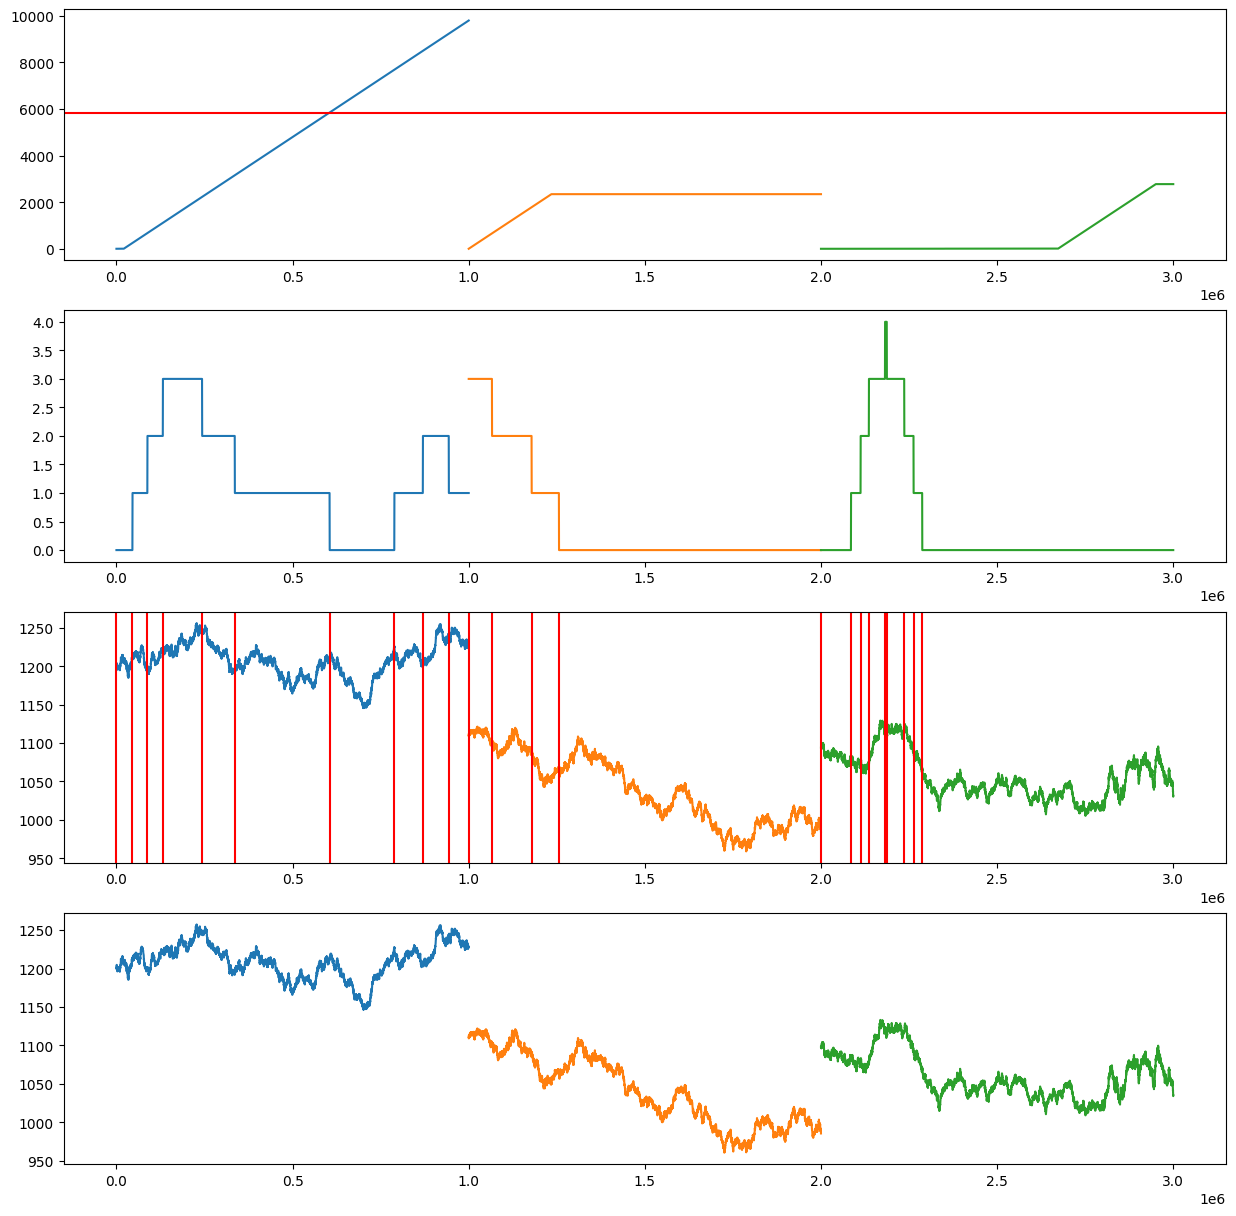

In [122]:
fig, axs = plt.subplots(4, figsize=(15, 15))

# plot the probability of production drop against the timestamp for the three days
axs[0].plot(data_day_n1['timestamp'], data_day_n1['cumulative_ticks_with_enough_sunlight'], label='day -1')
axs[0].plot(data_day_0['timestamp'], data_day_0['cumulative_ticks_with_enough_sunlight'], label='day 0')
axs[0].plot(data_day_1['timestamp'], data_day_1['cumulative_ticks_with_enough_sunlight'], label='day 1')
# put a red line at 5833
axs[0].axhline(y=5833, color='red')

# also plot the humidity effect on production
axs[1].plot(data_day_n1['timestamp'], data_day_n1['humidity_effect_on_production'], label='day -1')
axs[1].plot(data_day_0['timestamp'], data_day_0['humidity_effect_on_production'], label='day 0')
axs[1].plot(data_day_1['timestamp'], data_day_1['humidity_effect_on_production'], label='day 1')


# now plot the true price of the orchids
axs[2].plot(data_day_n1['timestamp'], data_day_n1['true_price'], label='true price')
changes_in_values = np.where(data_day_n1['humidity_effect_on_production'].diff() != 0)
for change in changes_in_values[0]:
    axs[2].axvline(x=change*100, color='red')
    

axs[2].plot(data_day_0['timestamp'], data_day_0['true_price'], label='price')
changes_in_values = np.where(data_day_0['humidity_effect_on_production'].diff() != 0)
for change in changes_in_values[0]:
    axs[2].axvline(x=change*100 + data_day_n1['timestamp'].iloc[-1] , color='red')



axs[2].plot(data_day_1['timestamp'], data_day_1['true_price'], label='price')
changes_in_values = np.where(data_day_1['humidity_effect_on_production'].diff() != 0)
for change in changes_in_values[0]:
    axs[2].axvline(x=change*100 + data_day_0['timestamp'].iloc[-1] , color='red')



# and finally the ORCHIDS
axs[3].plot(data_day_n1['timestamp'], data_day_n1['ORCHIDS'], label='ORCHIDS')
axs[3].plot(data_day_0['timestamp'], data_day_0['ORCHIDS'], label='ORCHIDS')
axs[3].plot(data_day_1['timestamp'], data_day_1['ORCHIDS'], label='ORCHIDS')

data_day_n1[data_day_n1['humidity_effect_on_production'] != 0]['timestamp'].iloc[0]


In [123]:
# find all the rows where the value of the humidity effect on production changes 


In [124]:

data.drop(columns=['enough_sunlight', 'enough_sunlight_count', 'cumulative_ticks_with_enough_sunlight', 'ticks_till_production_not_affected', 'remaining_ticks', 'DAY', 'timestamp', 'humidity_effect_on_production', 'SUNLIGHT'], inplace=True)
data

,ORCHIDS,TRANSPORT_FEES,EXPORT_TARIFF,IMPORT_TARIFF,HUMIDITY,probability_of_production_drop
0,1200.00,1.5,10.5,-2.0,79.00000,0.999829
1,1201.75,1.5,9.5,-2.0,79.00410,0.999829
2,1201.75,1.5,9.5,-2.0,79.00821,0.999829
3,1201.75,1.5,9.5,-2.0,79.01234,0.999829
4,1201.75,1.5,9.5,-2.0,79.01649,0.999829
...,...,...,...,...,...,...
9996,1036.25,0.9,9.5,-5.0,69.93549,1.000000
9997,1036.25,0.9,9.5,-5.0,69.95153,1.000000
9998,1036.25,0.9,9.5,-5.0,69.96762,1.000000
9999,1034.25,0.9,9.5,-5.0,69.98378,1.000000


In [125]:
data_X = data.loc[:,data.columns !=  'ORCHIDS' ]
data_Y = data['ORCHIDS']
train_X, test_X, train_y,test_y = train_test_split(data_X,data_Y,test_size=0.2)

print('\n\nTraining Set')
print(train_X.head())
print(train_y.head())



Training Set
      TRANSPORT_FEES  EXPORT_TARIFF  IMPORT_TARIFF  HUMIDITY  \
8034             1.3            9.5           -3.8  70.19951   
5783             0.9           10.5           -5.0  70.36503   
2605             1.4           10.5           -2.4  91.28169   
890              1.5            9.5           -2.2  92.05849   
3481             1.3            9.5           -2.4  87.06514   

      probability_of_production_drop  
8034                        1.000000  
5783                        1.000000  
2605                        0.588548  
890                         0.847248  
3481                        0.438368  
8034     975.75
5783    1054.75
2605    1231.75
890     1090.75
3481    1208.25
Name: ORCHIDS, dtype: float64


In [126]:
#Creating the Regressor
regressor = LinearRegression()
regressor.fit(train_X,train_y)

predict_y = regressor.predict(test_X)
print('Prediction Score : ' , regressor.score(test_X,test_y))

error = mean_squared_error(test_y,predict_y)
print('Mean Squared Error : ',error)

print(regressor.coef_)
print(regressor.intercept_)


Prediction Score :  0.7650777157764573
Mean Squared Error :  1584.482257946112
[  -1.56082021    2.16917055    0.78207945    4.97103892 -115.56464385]
774.8499470979681
